In [21]:
### Importing packages

import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl


In [8]:
#### function to import oecd data

import requests as rq
import pandas as pd
import re

OECD_ROOT_URL = "http://stats.oecd.org/SDMX-JSON/data"

def make_OECD_request(dsname, dimensions, params = None, root_dir = OECD_ROOT_URL):
    # Make URL for the OECD API and return a response
    # 4 dimensions: location, subject, measure, frequency
    # OECD API: https://data.oecd.org/api/sdmx-json-documentation/#d.en.330346

    if not params:
        params = {}

    dim_args = ['+'.join(d) for d in dimensions]
    dim_str = '.'.join(dim_args)

    url = root_dir + '/' + dsname + '/' + dim_str + '/all'

    print('Requesting URL ' + url)
    return rq.get(url = url, params = params)


def create_DataFrame_from_OECD(country = 'CZE', subject = [], measure = [], frequency = 'M',  startDate = None, endDate = None):     
    # Request data from OECD API and return pandas DataFrame

    # country: country code (max 1)
    # subject: list of subjects, empty list for all
    # measure: list of measures, empty list for all
    # frequency: 'M' for monthly and 'Q' for quarterly time series
    # startDate: date in YYYY-MM (2000-01) or YYYY-QQ (2000-Q1) format, None for all observations
    # endDate: date in YYYY-MM (2000-01) or YYYY-QQ (2000-Q1) format, None for all observations

    # Data download

    response = make_OECD_request('MEI'
                                 , [[country], subject, measure, [frequency]]
                                 , {'startTime': startDate, 'endTime': endDate, 'dimensionAtObservation': 'AllDimensions'})

    # Data transformation

    if (response.status_code == 200):

        responseJson = response.json()

        obsList = responseJson.get('dataSets')[0].get('observations')

        if (len(obsList) > 0):

            print('Data downloaded from %s' % response.url)

            timeList = [item for item in responseJson.get('structure').get('dimensions').get('observation') if item['id'] == 'TIME_PERIOD'][0]['values']
            subjectList = [item for item in responseJson.get('structure').get('dimensions').get('observation') if item['id'] == 'SUBJECT'][0]['values']
            measureList = [item for item in responseJson.get('structure').get('dimensions').get('observation') if item['id'] == 'MEASURE'][0]['values']

            obs = pd.DataFrame(obsList).transpose()
            obs.rename(columns = {0: 'series'}, inplace = True)
            obs['id'] = obs.index
            obs = obs[['id', 'series']]
            obs['dimensions'] = obs.apply(lambda x: re.findall('\d+', x['id']), axis = 1)
            obs['subject'] = obs.apply(lambda x: subjectList[int(x['dimensions'][1])]['id'], axis = 1)
            obs['measure'] = obs.apply(lambda x: measureList[int(x['dimensions'][2])]['id'], axis = 1)
            obs['time'] = obs.apply(lambda x: timeList[int(x['dimensions'][4])]['id'], axis = 1)
            obs['names'] = obs['subject'] + '_' + obs['measure']

            data = obs.pivot_table(index = 'time', columns = ['names'], values = 'series')

            return(data)

        else:

            print('Error: No available records, please change parameters')

    else:

        print('Error: %s' % response.status_code)

In [9]:
### testing 

data = create_DataFrame_from_OECD(country = 'CZE', subject = ['LOCOPCNO'])
data = create_DataFrame_from_OECD(country = 'USA', frequency = 'Q', startDate = '2009-Q1', endDate = '2010-Q1')
data = create_DataFrame_from_OECD(country = 'USA', frequency = 'M', startDate = '2009-01', endDate = '2010-12')
data = create_DataFrame_from_OECD(country = 'USA', frequency = 'M', subject = ['B6DBSI01'])
dataoecd = create_DataFrame_from_OECD(country = 'USA', frequency = 'Q', subject = ['B6DBSI01'])

Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CZE.LOCOPCNO..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/CZE.LOCOPCNO..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all?startTime=2009-Q1&endTime=2010-Q1&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA...M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA...M/all?startTime=2009-01&endTime=2010-12&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA.B6DBSI01..M/all
Error: No available records, please change parameters
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA.B6DBSI01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA.B6DBSI01..Q/all?dimensionAtObservation=AllDimensions


In [10]:
dataoecd.head()  

names,B6DBSI01_CXCU,B6DBSI01_CXCUSA,B6DBSI01_NCCU,B6DBSI01_NCCUSA
time,,,,
1960-Q1,958.0,955.0,958.0,955.0
1960-Q2,1172.0,1154.0,1172.0,1154.0
1960-Q3,896.0,889.0,896.0,889.0
1960-Q4,1035.0,1064.0,1035.0,1064.0
1961-Q1,991.0,989.0,991.0,989.0


In [27]:
### importing bis data
import pandas as pd 
import urllib
link = "https://www.bis.org/statistics/totcredit/totcredit.xlsx"
databis = pd.read_excel(link, sheet_name = 2)


In [28]:
### inspecting  data
databis.head()

,Back to menu,Emerging markets (aggregate) - Credit to Non financial sector from All sectors at Market value - Percentage of GDP - Adjusted for breaks,Emerging markets (aggregate) - Credit to Non financial sector from All sectors at Market value - Percentage of GDP (using PPP exchange rates) - Adjusted for breaks,Emerging markets (aggregate) - Credit to Non financial sector from All sectors at Market value - US dollar - Adjusted for breaks,Emerging markets (aggregate) - Credit to General government from All sectors at Nominal value - Percentage of GDP - Adjusted for breaks,Emerging markets (aggregate) - Credit to General government from All sectors at Nominal value - Percentage of GDP (using PPP exchange rates) - Adjusted for breaks,Emerging markets (aggregate) - Credit to General government from All sectors at Nominal value - US dollar - Adjusted for breaks,Emerging markets (aggregate) - Credit to Households and NPISHs from All sectors at Market value - Percentage of GDP - Adjusted for breaks,Emerging markets (aggregate) - Credit to Households and NPISHs from All sectors at Market value - Percentage of GDP (using PPP exchange rates) - Adjusted for breaks,Emerging markets (aggregate) - Credit to Households and NPISHs from All sectors at Market value - US dollar - Adjusted for breaks,...,South Africa - Credit to Non-financial corporations from All sectors at Market value - Domestic currency - Adjusted for breaks,South Africa - Credit to Non-financial corporations from All sectors at Market value - Domestic currency - Unadjusted,South Africa - Credit to Private non-financial sector from All sectors at Market value - Percentage of GDP - Adjusted for breaks,South Africa - Credit to Private non-financial sector from All sectors at Market value - US dollar - Adjusted for breaks,South Africa - Credit to Private non-financial sector from All sectors at Market value - Domestic currency - Adjusted for breaks,South Africa - Credit to Private non-financial sector from All sectors at Market value - Domestic currency - Unadjusted,"South Africa - Credit to Private non-financial sector from Banks, total at Market value - Percentage of GDP - Adjusted for breaks","South Africa - Credit to Private non-financial sector from Banks, total at Market value - US dollar - Adjusted for breaks","South Africa - Credit to Private non-financial sector from Banks, total at Market value - Domestic currency - Adjusted for breaks","South Africa - Credit to Private non-financial sector from Banks, total at Market value - Domestic currency - Unadjusted"
0,NaN,Per Cent (Units),Per Cent (Units),US dollar (Billions),Per Cent (Units),Per Cent (Units),US dollar (Billions),Per Cent (Units),Per Cent (Units),US dollar (Billions),...,Rand (Billions),Rand (Billions),Per Cent (Units),US dollar (Billions),Rand (Billions),Rand (Billions),Per Cent (Units),US dollar (Billions),Rand (Billions),Rand (Billions)
1,NaN,Emerging markets (aggregate),Emerging markets (aggregate),Emerging markets (aggregate),Emerging markets (aggregate),Emerging markets (aggregate),Emerging markets (aggregate),Emerging markets (aggregate),Emerging markets (aggregate),Emerging markets (aggregate),...,South Africa,South Africa,South Africa,South Africa,South Africa,South Africa,South Africa,South Africa,South Africa,South Africa
2,Period,Q:4T:C:A:M:770:A,Q:4T:C:A:M:799:A,Q:4T:C:A:M:USD:A,Q:4T:G:A:N:770:A,Q:4T:G:A:N:799:A,Q:4T:G:A:N:USD:A,Q:4T:H:A:M:770:A,Q:4T:H:A:M:799:A,Q:4T:H:A:M:USD:A,...,Q:ZA:N:A:M:XDC:A,Q:ZA:N:A:M:XDC:U,Q:ZA:P:A:M:770:A,Q:ZA:P:A:M:USD:A,Q:ZA:P:A:M:XDC:A,Q:ZA:P:A:M:XDC:U,Q:ZA:P:B:M:770:A,Q:ZA:P:B:M:USD:A,Q:ZA:P:B:M:XDC:A,Q:ZA:P:B:M:XDC:U
3,1940-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1940-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
### Inspecting world bank  Apis

wbdata.get_source()

1 	Doing Business
2 	World Development Indicators
3 	Worldwide Governance Indicators
5 	Subnational Malnutrition Database
6 	International Debt Statistics
11	Africa Development Indicators
12	Education Statistics
13	Enterprise Surveys
14	Gender Statistics
15	Global Economic Monitor
16	Health Nutrition and Population Statistics
18	IDA Results Measurement System
19	Millennium Development Goals
20	Quarterly Public Sector Debt
22	Quarterly External Debt Statistics SDDS
23	Quarterly External Debt Statistics GDDS
24	Poverty and Equity
25	Jobs
27	Global Economic Prospects
28	Global Financial Inclusion
29	The Atlas of Social Protection: Indicators of Resilience and Equity
30	Exporter Dynamics Database ��� Indicators at Country-Year Level
31	Country Policy and Institutional Assessment
32	Global Financial Development
33	G20 Financial Inclusion Indicators
34	Global Partnership for Education
35	Sustainable Energy for All
36	Statistical Capacity Indicators
37	LAC Equity Lab
38	Subnational Poverty
39

In [11]:

wbdata.get_indicator(source=15)

CORENS       	Core CPI,not seas.adj,,,
CORESA       	Core CPI,seas.adj,,,
CPTOTNSXN    	CPI Price, nominal
CPTOTSAXMZGY 	CPI Price, % y-o-y, median weighted, seas. adj.
CPTOTSAXN    	CPI Price, nominal, seas. adj.
CPTOTSAXNZGY 	CPI Price, % y-o-y, nominal, seas. adj.
DMGSRMRCHNSCD	Imports Merchandise, Customs, current US$, millions
DMGSRMRCHNSKD	Imports Merchandise, Customs, constant US$, millions
DMGSRMRCHNSXD	Imports Merchandise, Customs, Price, US$
DMGSRMRCHSACD	Imports Merchandise, Customs, current US$, millions, seas. adj.
DMGSRMRCHSAKD	Imports Merchandise, Customs, constant US$, millions, seas. adj.
DMGSRMRCHSAXD	Imports Merchandise, Customs, Price, US$, seas. adj.
DPANUSLCU    	Official exchange rate, LCU per USD, period average
DPANUSSPB    	Exchange rate, new LCU per USD extended backward, period average
DPANUSSPF    	Exchange rate, old LCU per USD extended forward, period average
DSTKMKTXD    	Stock Markets, US$
DSTKMKTXN    	Stock Markets, LCU
DXGSRMRCHNSCD	Exports Merchandi

In [64]:
### Creating dictionary of variables 

dictionary = dict([('NYGDPMKTPKDZ','Annual GDP Growth 2010'), 
                   ('CC.EST','Control of Corruption Estimate'),
               ('RL.EST'    ,  'Rule of Law: Estimate'),
               ('RQ.EST'    ,   'Regulatory Quality: Estimate'),
               ('VA.EST'    ,   'Voice and Accountability: Estimate'),
              (' PV.EST'    ,   'Political Stability and Absence of Violence/Terrorism: Estimate'),
                  ('CORENS'       ,'Core CPI,not seas.adj'),
                ('CORESA'        ,'Core CPI,seas.adj'),
                ('CPTOTNSXN'    ,'CPI Price, nominal'),
                ('CPTOTSAXMZGY' ,'CPI Price, % y-o-y, median weighted, seas. adj.'),
                ('CPTOTSAXN'    ,'CPI Price, nominal, seas. adj.'),
                ('CPTOTSAXNZGY' ,'CPI Price, % y-o-y, nominal, seas. adj.'),
                ('DMGSRMRCHNSCD','Imports Merchandise, Customs, current US$, millions'),
                ('DMGSRMRCHNSKD','Imports Merchandise, Customs, constant US$, millions'),
                ('DMGSRMRCHNSXD','Imports Merchandise, Customs, Price, US$'),
                ('DMGSRMRCHSACD','Imports Merchandise, Customs, current US$, millions, seas. adj.'),
                ('DMGSRMRCHSAKD','Imports Merchandise, Customs, constant US$, millions, seas. adj.'),
                ('DMGSRMRCHSAXD','Imports Merchandise, Customs, Price, US$, seas. adj.'),
                ('DPANUSLCU'    ,'Official exchange rate, LCU per USD, period average'),
                ('DPANUSSPB'    ,'Exchange rate, new LCU per USD extended backward, period average'),
                ('DPANUSSPF'    ,'Exchange rate, old LCU per USD extended forward, period average'),
                ('DSTKMKTXD'    ,'Stock Markets, US$'),
                ('DSTKMKTXN'    ,'Stock Markets, LCU'),
                ('DXGSRMRCHNSCD' ,'Exports Merchandise, Customs, current US$, millions'),
                ('DXGSRMRCHNSKD' ,'Exports Merchandise, Customs, constant US$, millions'),
                ('DXGSRMRCHNSXD' ,'Exports Merchandise, Customs, Price, US$'),
                ('DXGSRMRCHSACD' , 'Exports Merchandise, Customs, current US$, millions, seas. adj.'),
                ('DXGSRMRCHSAKD' ,'Exports Merchandise, Customs, constant US$, millions, seas. adj.'),
                ('DXGSRMRCHSAXD' ,'Exports Merchandise, Customs, Price, US$, seas. adj.'),
                ('EMBIG'        ,'J.P. Morgan Emerging Markets Bond Spread (EMBI+'),
                ('EMBIGI'       ,'J.P. Morgan Emerging Markets Bond Index(EMBI+'),
                ('IMPCOV'       ,'Foreign Reserves, Months Import Cover, Goods'),
                ('IPTOTNSKD'    ,'Industrial Production, constant US$'),
                ('IPTOTSAKD'    ,'Industrial Production, constant US$, seas. adj.'),
                ('NEER'         ,'Nominal Effecive Exchange Rate'),
                ('NYGDPMKTPSACD' ,'GDP,current US$,millions,seas. adj.'),
                ('NYGDPMKTPSACN' ,'GDP,current LCU,millions,seas. adj.'),
                ('NYGDPMKTPSAKD' ,'GDP,constant 2010 US$,millions,seas. adj.'),
                ('NYGDPMKTPSAKN' ,'GDP,constant 2010 LCU,millions,seas. adj.'),
                ('REER'          ,'Real Effective Exchange Rate'),
                ('RETSALESSA'    ,'Retail Sales Volume,Index,'),
                ('TOT'           ,'Terms of Trade'),
                ('TOTRESV'       ,'Total Reserves'),
                ('UNEMPSA_'      ,'Unemployment rate,Percent')
                  ])

In [66]:
### Testing Dictionary 

dictionary['TOT']

'Terms of Trade'

In [5]:
### structuring dates 

data_dates = (datetime.datetime(2001,1,1), datetime.datetime(2015,1,1))

In [54]:
### Creating indicator to input into api

indicator={'IMPCOV':'Foreign Reserves',
       'IPTOTSAKD':'Industrial Production',
       'NYGDPMKTPSAKD':'GDP,constant 2010',
       'CORESA':'Core CPI',
       'RL.EST':'Rule of Law: Estimate',
       'PV.EST':'Political Stability and Absence of Violence/Terrorism: Estimate',
       'NEER':'Nominal Effecive Exchange Rate',
       'DSTKMKTXD':'Stock Markets USD',
       'EMBIG':'J.P. Morgan Emerging Markets Bond Spread'
    }

In [55]:
### Building dataframe from APIs

df=wbdata.get_dataframe(indicator,country='all')

In [56]:
# inspecting dataframe
df.head()

Foreign Reserves  Industrial Production  \
country            date                                            
Advanced Economies 1987               NaN                    NaN   
                   1988               NaN                    NaN   
                   1989               NaN                    NaN   
                   1990               NaN                    NaN   
                   1991          0.232183           7.186165e+12   

                         GDP,constant 2010   Core CPI  Rule of Law: Estimate  \
country            date                                                        
Advanced Economies 1987       2.537671e+07  56.117876                    NaN   
                   1988       2.660831e+07  58.304588                    NaN   
                   1989       2.765369e+07  60.852758                    NaN   
                   1990       2.845964e+07  63.721509                    NaN   
                   1991       2.883952e+07  66.584499                    NaN   

                         Political Stability and Absence of Violence/Terrorism: Estimate  \
country            date                                                                    
Advanced Economies 1987                                                NaN                 
                   1988                                                NaN                 
                   1989                                                NaN                 
                   1990                                                NaN                 
                   1991                                                NaN                 

                         Nominal Effecive Exchange Rate  Stock Markets USD  \
country            date                                                      
Advanced Economies 1987                       76.776320                NaN   
                   1988                       78.932198                NaN   
                   1989                       82.927398                NaN   
                   1990                       86.575677                NaN   
                   1991                       88.445536                NaN   

                         J.P. Morgan Emerging Markets Bond Spread  
country            date                                            
Advanced Economies 1987                                       NaN  
                   1988                                       NaN  
                   1989                                       NaN  
                   1990                                       NaN  
                   1991                                       NaN

In [57]:
data = df.reset_index()


In [58]:
data.head()

,country,date,Foreign Reserves,Industrial Production,"GDP,constant 2010",Core CPI,Rule of Law: Estimate,Political Stability and Absence of Violence/Terrorism: Estimate,Nominal Effecive Exchange Rate,Stock Markets USD,J.P. Morgan Emerging Markets Bond Spread
0,Advanced Economies,1987,NaN,NaN,2.537671e+07,56.117876,NaN,NaN,76.776320,NaN,NaN
1,Advanced Economies,1988,NaN,NaN,2.660831e+07,58.304588,NaN,NaN,78.932198,NaN,NaN
2,Advanced Economies,1989,NaN,NaN,2.765369e+07,60.852758,NaN,NaN,82.927398,NaN,NaN
3,Advanced Economies,1990,NaN,NaN,2.845964e+07,63.721509,NaN,NaN,86.575677,NaN,NaN
4,Advanced Economies,1991,0.232183,7.186165e+12,2.883952e+07,66.584499,NaN,NaN,88.445536,NaN,NaN


In [ ]:
#### Profiling dataframe 

data.profile_report(style={'full_width':True})

# Data Wrangling

The following chunks of code will be devoted to wrangle the database

In [2]:
### DataWranling

## importing data base

import pandas as pd

dataset = pd.read_csv('full_data2.csv', parse_dates = ['TIME'])
dataset.head()

,Unnamed: 0,Country,TIME,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
0,1,Albania,1989-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Albania,1989-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Albania,1989-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Albania,1989-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Albania,1989-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
dataset.describe()

,Unnamed: 0,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
count,81591.000000,1.415600e+04,11385.000000,12257.000000,1.143700e+04,10911.000000,33863.000000,36748.000000,3.066800e+04,26563.000000,25826.000000,43204.000000,55085.000000
mean,40796.000000,4.953733e+07,64.916451,8.527778,3.681984e+06,-0.315748,1275.339498,102.643299,6.733597e+10,87.748906,8.282807,216.919592,89.576899
std,23553.437244,2.955378e+08,38.082163,14.361982,1.533867e+07,5.140970,19722.727233,95.832071,1.914169e+11,67.174914,5.275549,1400.621109,37.814284
min,1.000000,9.994000e+01,0.713413,-3.650000,1.277010e+02,-32.020580,29.190170,32.259500,2.956468e+07,0.000135,0.100000,0.001329,0.000319
25%,20398.500000,6.981983e+04,30.423246,2.520000,2.116556e+04,-3.286941,95.106390,91.658575,1.270000e+09,45.149235,5.000000,2.803465,70.074750
50%,40796.000000,3.333427e+05,66.092489,5.290000,7.168420e+04,-0.721417,100.643400,99.047810,7.100000e+09,82.287550,7.043791,5.275730,90.515540
75%,61193.500000,1.760274e+06,96.858624,9.628600,3.060218e+05,2.246951,110.385100,105.298175,2.890000e+10,114.050550,9.900000,9.850212,108.849200
max,81591.000000,4.310000e+09,174.292423,400.270000,1.483516e+08,43.330140,463330.200000,5102.158000,1.750000e+12,1765.503000,38.364440,28072.150000,530.559300


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750122 entries, 0 to 1750121
Data columns (total 14 columns):
Unnamed: 0         int64
Country            object
TIME               datetime64[ns]
housepi            float64
NOMexchange        float64
interbank          float64
fixedcap           float64
accountgdp         float64
REexchange         float64
nominalgdp         float64
industrialprod     float64
stock              float64
foreignreserver    float64
CPI                float64
dtypes: datetime64[ns](1), float64(11), int64(1), object(1)
memory usage: 186.9+ MB


Creating list of countries in order to remove regions such as: advanced economies, emerging markets... and leaving just standalone countries

In [4]:
#### creating list of countries

list = pd.DataFrame(dataset.Country.unique())
list.head()

,0
0,Albania
1,Argentina
2,Armenia
3,Australia
4,Austria


In [5]:
### fecthing country names from IMF database
countrycodes = pd.read_csv('CountryCodes.csv', delimiter = ';')
countrycodes.head()

,IMF Name,ISO Code,IMF Code
0,Afghanistan,AFG,512.0
1,Albania,ALB,914.0
2,Algeria,DZA,612.0
3,Angola,AGO,614.0
4,Argentina,ARG,213.0


In [6]:
### removing regions and keeping only standalone countries
dataset2 = dataset[dataset['Country'].isin(countrycodes['IMF Name'])]
dataset2.head()

,Unnamed: 0,Country,TIME,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
0,1,Albania,1989-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Albania,1989-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Albania,1989-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Albania,1989-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Albania,1989-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
### Checking if there are only standalone countries
list2 = pd.DataFrame(dataset2.Country.unique())
list2

,0
0,Albania
1,Argentina
2,Armenia
3,Australia
4,Austria
5,Belgium
6,Bulgaria
7,Bahrain
8,Bosnia and Herzegovina
9,Belarus


In [8]:
dataset3 = dataset2[(dataset2['TIME']) > pd.Timestamp(1990,1,1)]
dataset3.head()

,Unnamed: 0,Country,TIME,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
6,7,Albania,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Albania,1990-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,Albania,1990-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,Albania,1990-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,11,Albania,1990-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
### checking dataset3
dataset3.describe()

,Unnamed: 0,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
count,59502.000000,1.317600e+04,8261.000000,9081.000000,9.670000e+03,8816.000000,26275.000000,28110.000000,2.474800e+04,23335.000000,20637.000000,36185.000000,43818.000000
mean,38300.889752,4.274098e+07,77.988210,8.179477,4.327936e+06,-0.376444,1335.346831,98.184325,2.140265e+10,88.016707,8.146607,230.739680,89.856369
std,24230.487731,2.729556e+08,31.762155,14.864289,1.660007e+07,5.527397,22116.412814,14.830790,5.024659e+10,68.751402,4.941780,1485.062499,38.096341
min,7.000000,1.354800e+02,5.787204,-3.650000,1.277010e+02,-32.020580,29.190170,32.259500,2.956468e+07,1.767549,0.100000,0.001329,0.000321
25%,17136.250000,6.853440e+04,54.363059,2.000000,2.479996e+04,-3.558403,94.404485,91.171540,1.070000e+09,44.726935,4.900000,2.694087,70.637500
50%,35167.500000,3.229795e+05,80.900052,5.020000,7.887119e+04,-1.139357,100.213700,98.548475,5.780000e+09,82.315400,7.100000,4.995317,90.827795
75%,60690.750000,1.490000e+06,100.594138,9.000000,3.133832e+05,2.633283,108.967200,104.605800,1.540000e+10,114.687600,9.907407,9.248475,108.575400
max,81229.000000,3.860000e+09,174.292423,400.270000,1.483516e+08,43.330140,463330.200000,196.024700,5.040000e+11,1765.503000,29.500000,28072.150000,530.559300


In [10]:
### sorting values in dataset3 and assigning it to dataset4
dataset4 = dataset3.sort_values(by='TIME')
dataset4.head()

,Unnamed: 0,Country,TIME,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
6,7,Albania,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55176,55177,Lesotho,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54573,54574,St. Lucia,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54211,54212,Lebanon,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52056,52057,Guyana,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Choosing Sample size

Here we define the sample size that is going to be inserted into the pipeline. 

The idea here is to have flexibility and to try different choices.

i) First option is to follow ECB paper plus countries that are richer in data.




In [29]:
### fetching data from oecdplus
oecdplus =pd.read_csv('oecdplus.csv', parse_dates = True)
oecdplus                                    
                                    

,Unnamed: 0,Country,TIME,accountgdp
0,1,Australia,1959-07-01,-2.622289
1,2,Australia,1959-10-01,0.073493
2,3,Australia,1960-01-01,-1.561749
3,4,Australia,1960-04-01,-3.408831
4,5,Australia,1960-07-01,-5.508764
5,6,Australia,1960-10-01,-4.319313
6,7,Australia,1961-01-01,-3.534209
7,8,Australia,1961-04-01,0.046339
8,9,Australia,1961-07-01,0.624277
9,10,Australia,1961-10-01,2.270122


In [30]:
### list of oecd plus affiliated countries
oecdlist = pd.DataFrame(oecdplus.Country.unique())
oecdlist

,0
0,Australia
1,Korea
2,United States
3,Canada
4,Japan


In [32]:
### keeping only oecd plus countries
dataset5 = dataset4[dataset4['Country'].isin(oecdplus['Country'])]
dataset5.head()

,Unnamed: 0,Country,TIME,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
42359,42360,South Africa,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.632640
40653,40654,United States,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.96532,5.300000,NaN,58.853820
38519,38520,Turkey,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.48368,NaN,NaN,0.058567
37153,37154,Sweden,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.02149,1.959847,NaN,66.069290
34797,34798,Saudi Arabia,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.900900


In [34]:
### selecting unique values in dataset5
list3 = pd.DataFrame(dataset5.Country.unique())

In [35]:
#### List of selected countries
list3

,0
0,South Africa
1,United States
2,Turkey
3,Sweden
4,Saudi Arabia
5,Argentina
6,Portugal
7,Greece
8,United Kingdom
9,France


In [37]:
### sorting values in dataset5 and assigning it to dataset6
dataset6 = dataset5.sort_values(by='TIME')
dataset6.head()

,Unnamed: 0,Country,TIME,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
42359,42360,South Africa,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.63264
2240,2241,Belgium,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.749932,NaN,66.39466
16813,16814,Hungary,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31060,31061,New Zealand,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.161031,NaN,NaN
30346,30347,Norway,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.900000,NaN,64.58333


In [39]:
### Profiling dataset6
profile = dataset6.profile_report(style={'full_width':True})
profile.to_file(output_file="output.html")

In [41]:
dataset7 = dataset6.interpolate()
dataset7

,Unnamed: 0,Country,TIME,nominalgdp,housepi,interbank,fixedcap,accountgdp,NOMexchange,REexchange,industrialprod,stock,unemployment,foreignreserver,CPI
42359,42360,South Africa,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.632640
2240,2241,Belgium,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.749932,NaN,66.394660
16813,16814,Hungary,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.955481,NaN,65.790883
31060,31061,New Zealand,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.161031,NaN,65.187107
30346,30347,Norway,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.900000,NaN,64.583330
29839,29840,Netherlands,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.508560,4.166667,NaN,64.475100
26629,26630,Mexico,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.925301,2.433333,NaN,10.824140
32383,32384,Poland,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.736401,0.700000,NaN,5.324639
25196,25197,Latvia,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.547501,1.208226,NaN,2.662480
4412,4413,Brazil,1990-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.358600,1.716453,NaN,0.000321


In [42]:
dataset7.profile_report(style={'full_width':True})

In [ ]:
### Interpolation?

one option: MICE strategy statstools
    
    

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# a scatter plot comparing num_children and num_pets
dataset7.plot(kind='scatter',x='TIME',y='nominalgdp',color='red')
plt.show()

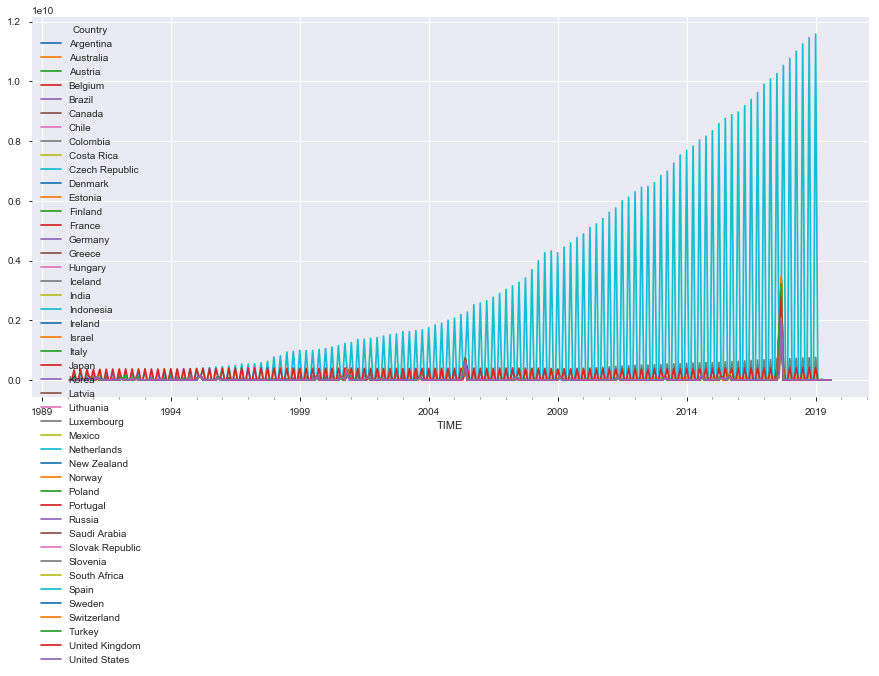

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
dataset7.groupby(['TIME','Country']).sum()['nominalgdp'].unstack().plot(ax=ax)

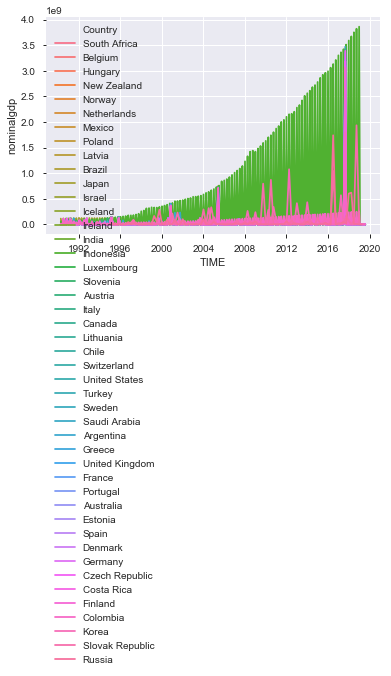

In [48]:
import seaborn as sns
ax = sns.lineplot(x="TIME", y="nominalgdp", hue="Country", data=dataset7)

In [51]:
dataset7.to_csv('File Name.csv')

## Dependent Variable and Sensitivity Analysis

In this section we are going to create different kinds of target (dependent) variables based on the research papers from the ECB.

i) Nominal Exchange Depreciation > 20%
ii) Sistemic Banking Crises


This tool is inteded to be flexible enough as to allow the inputation of different cenarios. 



In [ ]:
### building dependent variables and sensitivity analysis

# Create a new column called df.target where the value is 1
# if df.debt is greater than 90 and 0 if not
df['target'] = np.where(df['debt']>=50, '1', '0')

# nominal exchange rate depreciation

## monthly time series

### ten or twenty depreciation in a monthly 

# nominal exchange rate


### list of historical crises 


### Stationarity

This section is devoted to buid a tool for assessing stationarity in the dataframe´s time series.

In [17]:
### stationarity and non stationarity discussion 
from statsmodels.tsa.stattools import adfuller

def stationarity test
"Loop over df and run stationarity tests in each column"
for column in df:
    apply.(adfuller)
    return 
    
    
adf_test = adfuller(data['B6DBSI01_CXCU'])
adf_test


(2.9061435259309514,
 1.0,
 12,
 224,
 {'1%': -3.459884913337196,
  '5%': -2.8745310704320794,
  '10%': -2.573693840082908},
 4051.4409350527517)

In [ ]:
### build indicators


In [85]:
### Preparing machine learning pipeline 

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


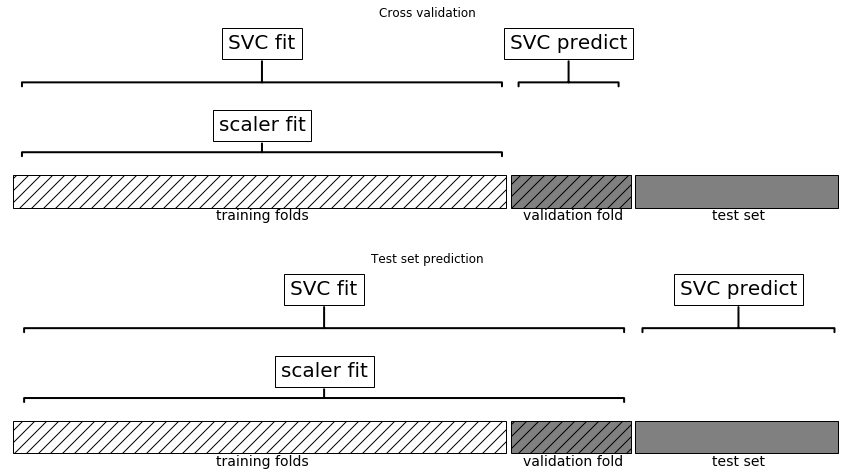

In [89]:
#### Describing what a ML pipeline looks like.

import mglearn 
mglearn.plots.plot_proper_processing()

In [102]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [103]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [104]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


In [105]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [106]:
pipe.fit(X_train, y_train)

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [107]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [108]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


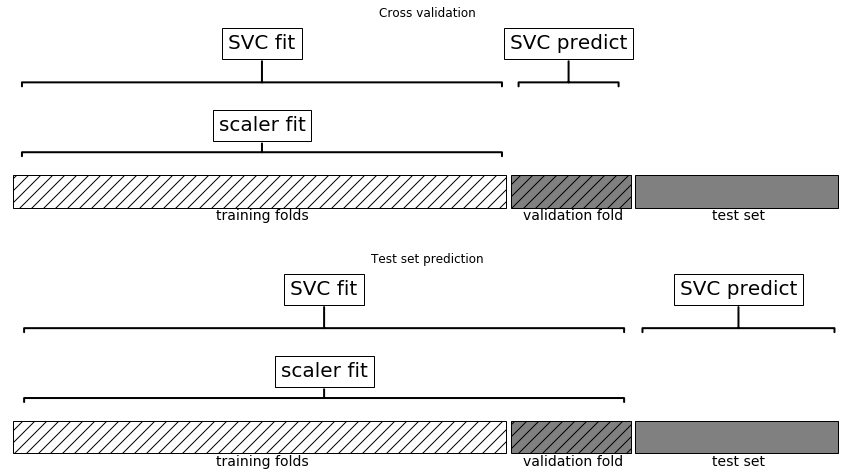

In [109]:
mglearn.plots.plot_proper_processing()